# Direct Imputation

In [2]:
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.style as style; #style.use('ggplot')

from util.gmm import EXAMPLE
from util.expectiles import expectile

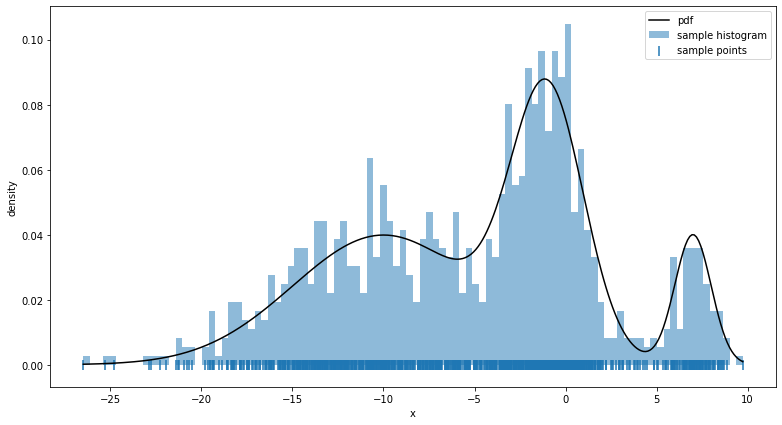

In [3]:
SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000)

## Derivative-based imputation

The original paper (*Newey and Powell (1987) Asymmetric Least Squares Estimation and Testing*) introducing expectile regression gives the following theorem:

> **Theorem 1 (iv)** [paraphrased]
> 
> Let $F$ be the continuously differentiable cumulative density function
> of a random variable.
> Let $I_F = \{y | 0 < F(y) < 1\}$.
> Let $\epsilon(\tau)$ be the expectile function (the one minimising the
> asymmetric least squares regression loss).
> 
> * $\epsilon(\tau)$ is continuously differentiable.
>   Let $\epsilon'(\tau)$ be its derivative.
> * Let $\mu$ be the mean of $F$ ($\mu=\epsilon(0.5)$).
>   Then for $y \in I_F$ with $y \neq \mu$, and
>   $\tau(y) \doteq \epsilon^{-1}(y)$,
> 
>     $$F(y)
        =
        -\frac{
            y - \mu + \tau(y) \epsilon'(\tau(y)) (1-2\tau(y))
        }{
            \epsilon'(\tau(y))(1-2\tau(y))^2
        }
      $$

Could we differentiate again to get $f'(y)$, and thus have an approximate imputation procedure given enough expectiles? Or is there not enough information here? What's the catch?

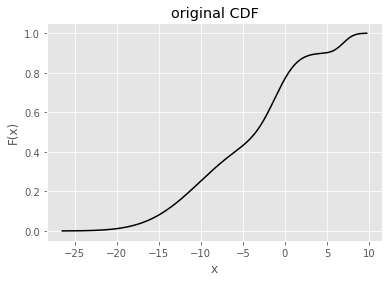

In [5]:
# Plot cumulative distribution function of sample
x = GMM_X
fx = GMM_Y
dx = x[1]-x[0]
Fx = fx.cumsum()*dx
plt.plot(x, Fx, color="black")
plt.xlabel("x")
plt.ylabel("F(x)")
plt.title("original CDF")
plt.show()

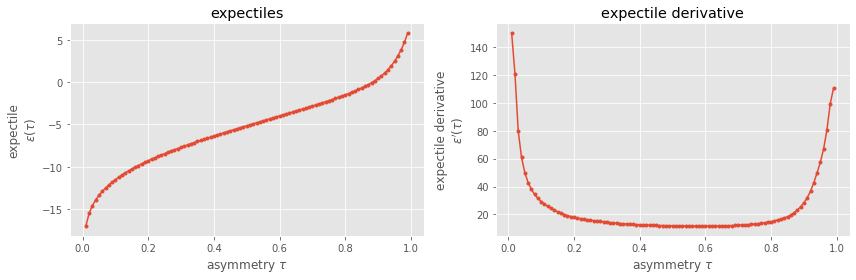

In [6]:
# Plot expectile function and derivative
taus  = np.linspace(0.01, 0.99, 99)
expt  = expectile(SAMPLE, taus)
exptd = np.gradient(expt, taus)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(taus, expt, marker=".")
ax1.set_title("expectiles")
ax1.set_xlabel("asymmetry $\\tau$")
ax1.set_ylabel("expectile\n$\\epsilon(\\tau)$")
ax2.plot(taus, exptd, marker=".")
ax2.set_title("expectile derivative")
ax2.set_xlabel("asymmetry $\\tau$")
ax2.set_ylabel("expectile derivative\n$\\epsilon'(\\tau)$")
plt.tight_layout()
plt.show()

<ipython-input-7-6673e00b1418>:14: RuntimeWarning: divide by zero encountered in true_divide
  Fy = - (y - m + taus * exptd * (1-2*taus)) / (exptd * (1-2*taus) ** 2)


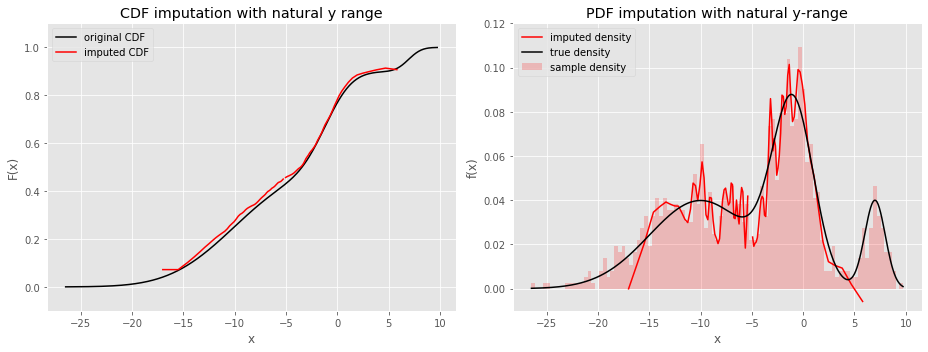

In [7]:
# Given the formula,
#          y - \mu + \tau_y * \epsilon'(\tau_y) * (1-2\tau_y)
# F(y) = - --------------------------------------------------
#                  \epsilon'(\tau_y) * (1-2\tau_y)^2
# NOTE: We could use a fixed-space set of ys, 'inverting' the expectile
# function (with or without interpolation***)
# y = GMM_X
# t = np.searchsorted(expt[:-1], y)
# BUT:Since our intention to take derivatives afterwards, it will be simpler
# to use the expectiles as the y values, and tau array as the inverses!
y = expt
m = SAMPLE.mean()

Fy = - (y - m + taus * exptd * (1-2*taus)) / (exptd * (1-2*taus) ** 2)
fy = np.gradient(Fy, y)

# plot the resulting imputed functions next to the original functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ax1.set_title("CDF imputation with natural y range")
ax1.set_xlabel("x")
ax1.set_ylabel("F(x)")
ax1.plot(x, Fx, label="original CDF", color="black")
ax1.plot(y, Fy, label="imputed CDF",  color="red")
ax1.set_ylim([-0.1, 1.1])
ax1.legend()

ax2.set_title("PDF imputation with natural y-range")
ax2.set_xlabel("x")
ax2.set_ylabel("f(x)")
ax2.plot(y, fy, label="imputed density", color="red")
ax2.plot(x, fx, label="true density", color="black")
ax2.hist(SAMPLE, density=True, bins=99, label="sample density", color="red", alpha=0.2)
ax2.set_ylim([-0.01, 0.12])
ax2.legend()

plt.tight_layout()
plt.show()

That works so well!

In fact, the spiky-ness is revealed to be recovering the noise in the sample itself! (Matches perfectly with the histogram)

Let's turn it into a function so that we can play with the tau range and density

In [78]:
def direct_impute(taus, epss=None, sample=SAMPLE, x=GMM_X, fx=GMM_Y, remove_mean=True,
                  remove_mean_width=0, smoothing=True, smoothing_bins=50, ylim=True):
    Fx = fx.cumsum()*(x[1]-x[0])
    half = np.where(np.isclose(taus, 0.5, atol=remove_mean_width))
    taus = np.delete(taus, half)
    if epss is not None:
        epss = np.delete(epss, half)
    else:
        epss = expectile(sample, taus)
    
    y = epss
    m = sample.mean()
    
    # epss'
    epssd = np.gradient(epss, taus)
    
    Fy = - (y - m + taus * epssd * (1-2*taus)) / (epssd * (1-2*taus) ** 2)
    fy = np.gradient(Fy, y)
    
    if smoothing:
        # to remove the noisy-ness we can do some simple fixed-width-bin smoothing
        w = (y[-1]-y[0])/smoothing_bins
        fys = np.zeros_like(fy)
        for i in range(len(y)):
            # TODO: vectorise
            fys[i] = np.mean(fy[np.abs(y - y[i]) < w])

    # plot the resulting imputed functions next to the original functions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.set_title("CDF imputation with natural y range")
    ax1.set_xlabel("x")
    ax1.set_ylabel("F(x)")
    ax1.plot(x, Fx, label="original CDF", color="black")
    ax1_default_ylim = ax1.get_ylim()
    ax1.plot(y, Fy, label="imputed CDF",  color="red")
    ax1.legend()

    ax2.set_title("PDF imputation with natural y-range")
    ax2.set_xlabel("x")
    ax2.set_ylabel("f(x)")
    ax2.plot(x, fx, label="true density", color="black")
    ax2_default_ylim = ax2.get_ylim()
    ax2.plot(y, fy, label="imputed density\n(before smoothing)", color="red", alpha=0.5)
    if smoothing:
        ax2.plot(y, fys,label="imputed density\n(after smoothing)", color="red", linewidth=4)
    ax2.legend()
    
    if ylim:
        ax1.set_ylim(ax1_default_ylim)
        ax2.set_ylim(ax2_default_ylim)
    
    plt.tight_layout()
    plt.show()

99 taus


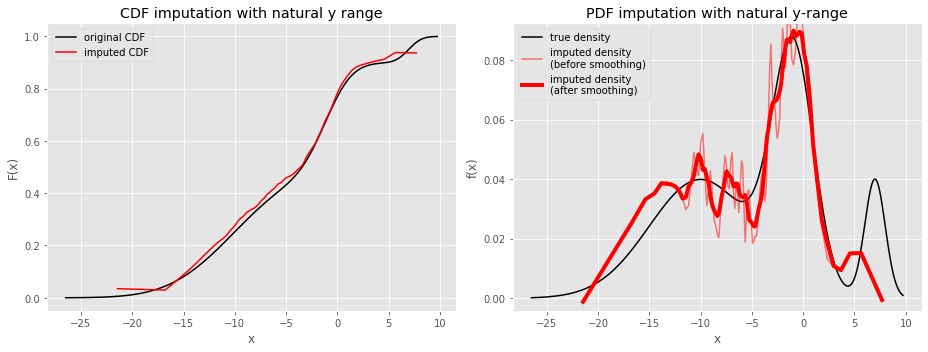

999 taus


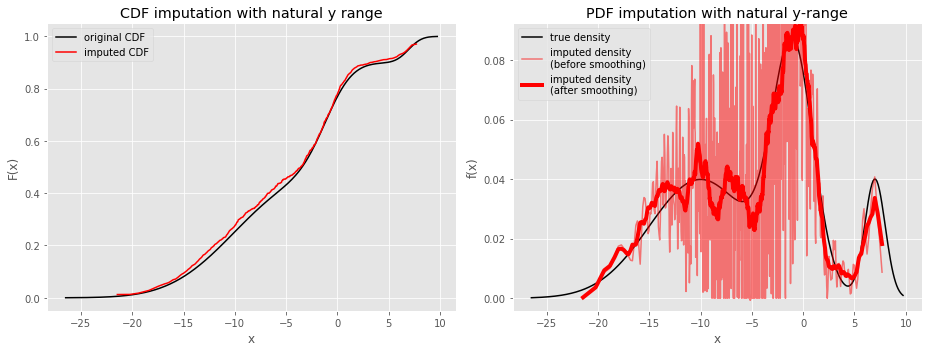

99 low taus


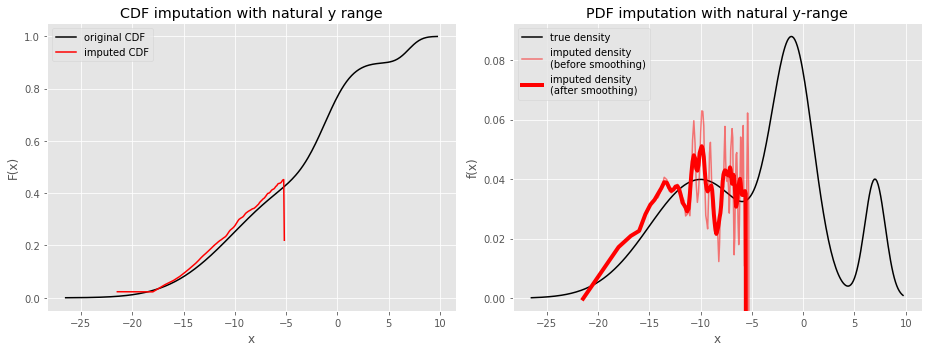

99 high taus


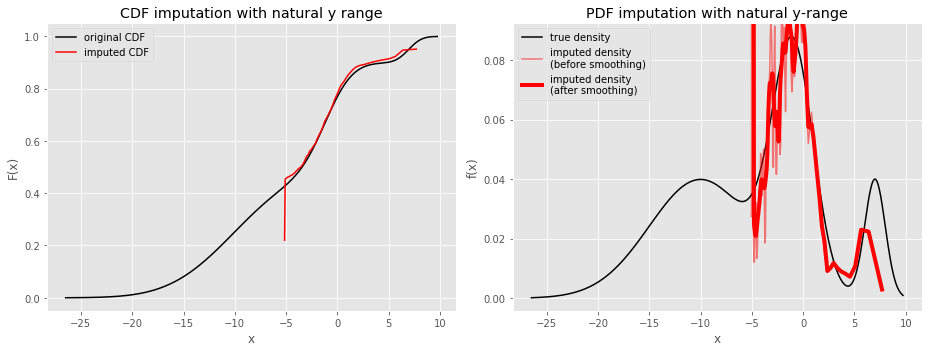

In [79]:
print("99 taus")
direct_impute(taus=np.linspace(0.001, 0.999, 99))
print("999 taus")
direct_impute(taus=np.linspace(0.001, 0.999, 999))
print("99 low taus")
direct_impute(taus=np.linspace(0.001, 0.499, 99))
print("99 high taus")
direct_impute(taus=np.linspace(0.501, 0.999, 99))

### Recovering the distribution from neural taus

How does the *neural* tau distribution go? (the expectiles were trained on a different
distribution, but we can still use the tau values for OUR distribution):

40 evenly spaced taus


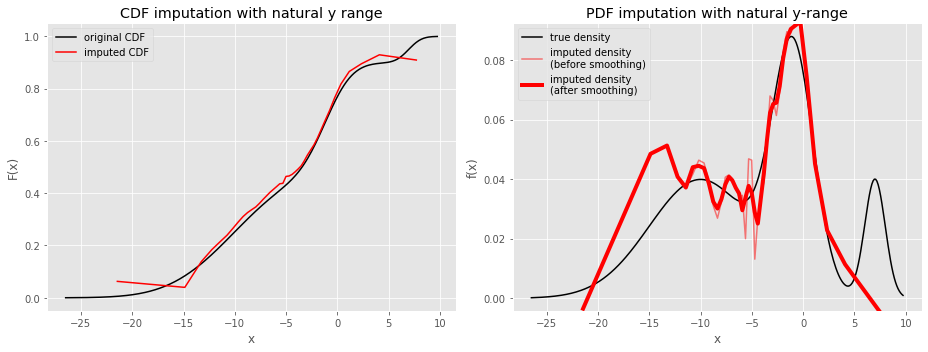

neural taus


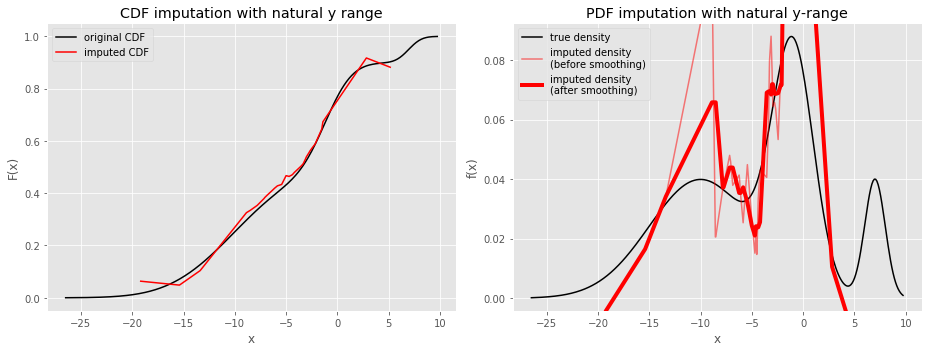

neural taus with a bit more smoothing


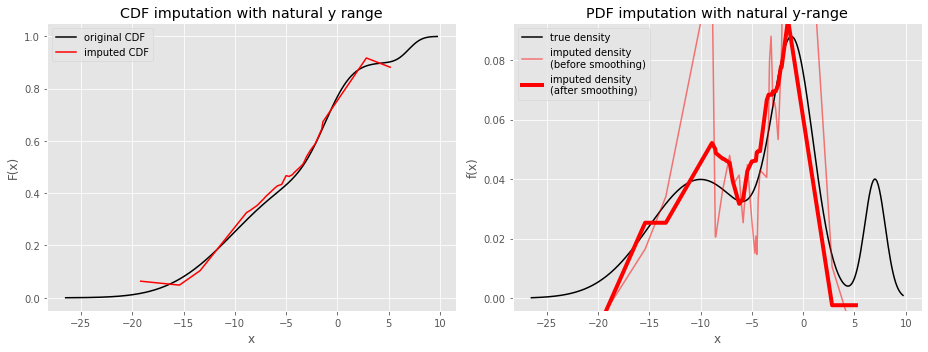

In [80]:
print("40 evenly spaced taus")
direct_impute(taus=np.linspace(0.001, 0.999, 40))

print("neural taus")
neural_taus = np.array([0.00336147, 0.02108205, 0.04991431, 0.24368197, 0.42196866,
                        0.22353116, 0.47702077, 0.29611582, 0.36181693, 0.442517  ,
                        0.51354238, 0.29136287, 0.24596278, 0.33895973, 0.41090296,
                        0.54775816, 0.2238155 , 0.98442344, 0.53931528, 0.41450776,
                        0.56729758, 0.58246691, 0.68976626, 0.34638865, 0.55480031,
                        0.5570765 , 0.66221661, 0.71219295, 0.65433601, 0.79852221,
                        0.75769016, 0.70370061, 0.7311324 , 0.63879298, 0.66074851,
                        0.68294063, 0.75187872, 0.80620104, 0.67485657, 0.95602078])
# note: we need them to be sorted
neural_taus.sort()
direct_impute(taus=neural_taus)

print("neural taus with a bit more smoothing")
direct_impute(taus=neural_taus, smoothing_bins=10)

Answer: Not bad! But could probably be better. And, it's not clear how much smoothing to rely on.

What if we use the actual reward distribution from the study? That is...

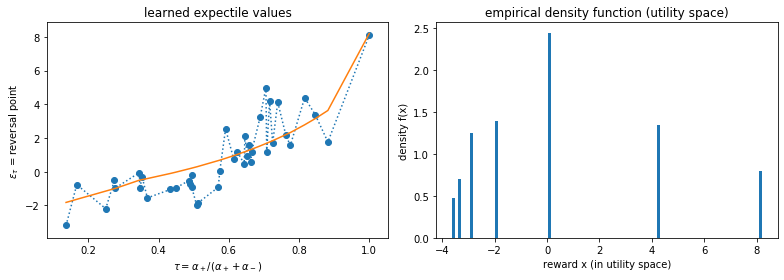

In [99]:
# DEEPMIND DATA DUMP (variables renamed, comments added)
# juice volumes in micro-litres
juice_vols = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])
# juice volumes in estimated utility space
juice_utils = np.array([-3.63887402657031,-3.31870708722146,  -2.84609534101164,
                        -1.86975535870141, 0.0350553672638314, 4.18830501181676,
                         8.20381872775166])
# juice empirical probabilities
juice_probs = np.array([0.06612594, 0.09090909, 0.14847358, 0.15489467,
                       0.31159175, 0.1509519 , 0.07705306])
# estimated neural asymmetries (neural taus)
neural_asyms = np.array([0.665148134736891,0.65208410906952,0.613744203780139,
                         0.775212700883808,0.707915816841008,0.570103354233973,
                         0.882127332095316,0.508575044586604,0.486016624470385,
                         0.490519368353783,0.353180140687647,0.34502602367731,
                         0.274459190431141,0.624608202330519,0.511245599898681,
                         0.275963695780172,0.574282416537853,0.494461077846514,
                         0.249573167763381,1.01616027303818, 0.136555552978056,
                         0.716127024137563,0.658310695222273,0.493856204792549,
                         0.815972879462343,0.433624365681467,0.643716612535732,
                         0.724905499014785,0.3681787227383,  0.705733696238299,
                         0.76246447053036, 0.739327730375869,0.590831434674471,
                         0.346659782367775,0.449000983609862,0.662902110431635,
                         0.645905621173483,0.16704746815482, 0.846125077182948,
                         0.689060956288534])
neural_asyms = np.clip(neural_asyms, 0., 1.)
# estimated neural expectile values (neural reversal points) in utility space
neural_expts = np.array([ 1.19796718528621,  0.909588860368442,  0.768290210301997,
                          1.5580695804582,   1.18069340075516,  -0.917277009040899,
                          1.76606208326366, -1.99990282124502,  -0.52508567014901,
                         -0.72677865537825, -0.317750664489987, -0.0555191676477702,
                         -0.498294836948614, 1.16799418233059,  -1.86969915298433,
                         -0.980841264017123, 0.0346564269295749,-0.917418194178877,
                         -2.19520456394411,  8.10381872775166,  -3.18979437039029,
                          4.18823808094621,  1.59258444073823,  -0.210742609830699,
                          4.38901915501838, -1.0533487207759,    0.472919232719837,
                          1.69636515581653, -1.55263442315208,   4.99096579152878,
                          2.16489750392618,  4.1202653189854,    2.53839455360929,
                         -0.981001892834966,-0.967509962517738,  0.554271248178451,
                          2.11181823971785, -0.766921663162386,  3.38445321759506,
                          3.21931839438752])
# END DEEPMIND DATA DUMP

# i'm going to need these to be sorted according to the taus
order = np.argsort(neural_asyms)
neural_asyms = neural_asyms[order]
neural_expts = neural_expts[order]

# and i'm going to need a sample
neural_sample = np.random.choice(juice_utils, p=juice_probs, size=1000)

# let's take a look!
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.set_title("learned expectile values")
ax1.set_ylabel(r"$\epsilon_\tau$ = reversal point")
ax1.set_xlabel(r"$\tau = \alpha_+ / (\alpha_++\alpha_-)$")
ax1.plot(neural_asyms, neural_expts, linestyle=":")
ax1.plot(neural_asyms, expectile(neural_sample, neural_asyms))
ax1.scatter(neural_asyms, neural_expts)
ax2.set_title("empirical density function (utility space)")
ax2.set_xlabel("reward x (in utility space)")
ax2.set_ylabel("density f(x)")
ax2.hist(neural_sample, bins=100, density=True)
plt.tight_layout()
plt.show()

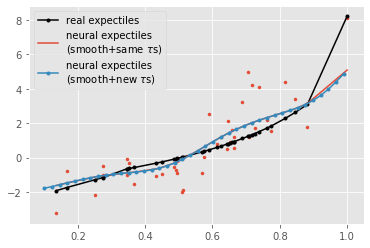

In [82]:
# i'm going to need the expectiles to be roughly smoothed so that the
# gradient calculation makes sense
def smooth(fy, y, w=1, y_=None):
    if y_ is None:
        y_ = y
    D = y_[:, np.newaxis] - y[np.newaxis]
    W = np.exp(-D**2/w)
    W = W / np.sum(W, axis=1)[:, np.newaxis]
    fy_smooth = W @ fy
    return fy_smooth

# expectiles of the sample
plt.plot(neural_asyms, expectile(neural_sample, neural_asyms),
         marker=".", label="real expectiles", color="black")

# compare the smoothed version
neural_expts_smooth = smooth(neural_expts, neural_asyms, w=0.02)
plt.plot(neural_asyms, neural_expts_smooth, label="neural expectiles\n(smooth+same $\\tau$s)")
plt.scatter(neural_asyms, neural_expts, marker=".")

# and the spread-ed smooth version
neural_asyms_spread = np.linspace(0.1, 0.99, 40)
neural_expts_spread = smooth(neural_expts, neural_asyms, w=0.02, y_=neural_asyms_spread)
plt.plot(neural_asyms_spread, neural_expts_spread,
         marker=".", label="neural expectiles\n(smooth+new $\\tau$s)")

plt.legend()
plt.show()

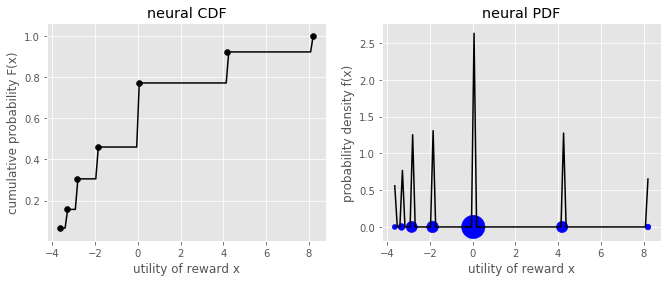

In [83]:
neural_x_range = [neural_sample.min(), neural_sample.max()]
neural_x_res = 100
neural_x = np.linspace(*neural_x_range, neural_x_res)
neural_dx = np.diff(neural_x_range) / neural_x_res
neural_fx = np.zeros_like(neural_x)
neural_fx[np.searchsorted(neural_x, juice_utils)] = juice_probs / neural_dx
neural_Fx = neural_fx.cumsum()*neural_dx

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.set_title("neural CDF")
ax1.set_xlabel("utility of reward x")
ax1.set_ylabel("cumulative probability F(x)")
ax1.scatter(juice_utils, juice_probs.cumsum(), color="black")
ax1.plot(neural_x, neural_Fx, color="black")
ax2.set_title("neural PDF")
ax2.set_xlabel("utility of reward x")
ax2.set_ylabel("probability density f(x)")
ax2.scatter(juice_utils, np.zeros_like(juice_utils), s=(75*juice_probs)**2, color="blue")
ax2.plot(neural_x, neural_fx, color="black")
plt.show()

Based on sample expectiles and real taus:


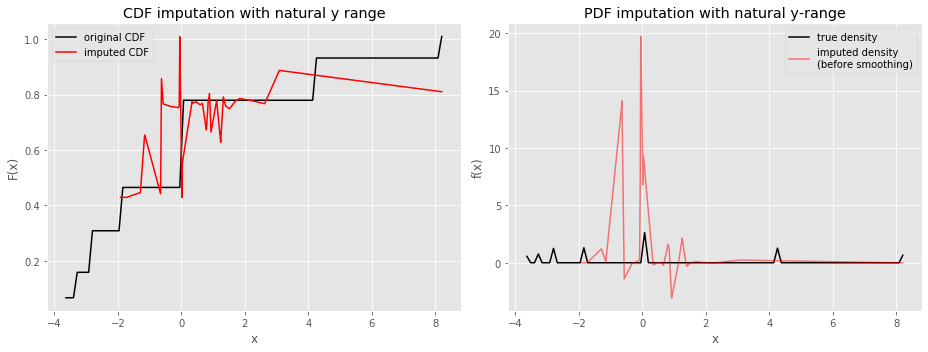

Based on sample expectiles and spread taus:


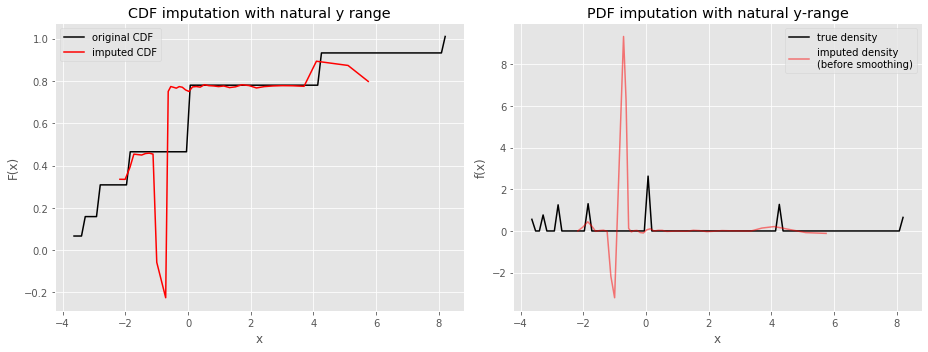

Based on smoothed expectiles and spread taus:


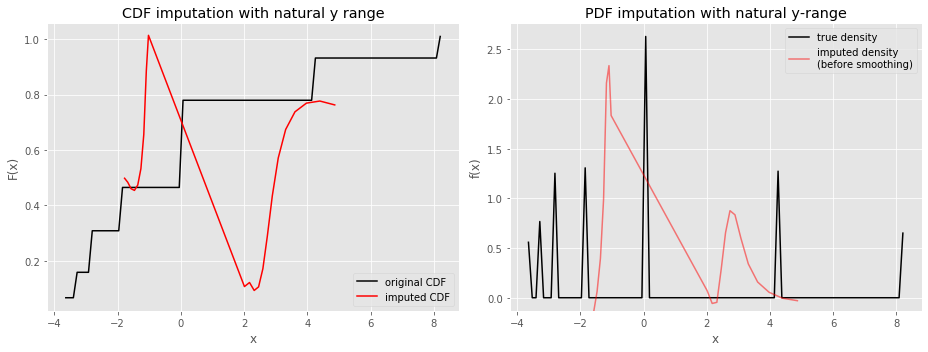

In [85]:
print("Based on sample expectiles and real taus:")
direct_impute(taus=neural_asyms, epss=expectile(neural_sample, neural_asyms), sample=neural_sample,
              x=neural_x, fx=neural_fx, smoothing=False, remove_mean_width=0, ylim=False)
print("Based on sample expectiles and spread taus:")
direct_impute(taus=neural_asyms_spread, epss=expectile(neural_sample, neural_asyms_spread), sample=neural_sample,
              x=neural_x, fx=neural_fx, smoothing=False, remove_mean_width=0, ylim=False)
print("Based on smoothed expectiles and spread taus:")
direct_impute(taus=neural_asyms_spread, epss=neural_expts_spread, sample=neural_sample,
              x=neural_x, fx=neural_fx, smoothing=False, remove_mean_width=0.2, ylim=True)

## A new approach

In [164]:
import  scipy.special as sp
import scipy.interpolate as ip

def tauspace(k):
    if not k % 2: raise ValueError("k must be odd.")
    e = 1/(2*k)
    return np.linspace(e, 1-e, k)

def exp_smooth(x, y, newx=None, ω=1):
    """
    Given x, y(x), compute y^~(newx), smoothed version, with bandwidth ω
    """
    if newx is None: newx=x
    W = np.exp(-np.square(newx[:, np.newaxis] - x)/ω)
    W /= W.sum(axis=-1, keepdims=True)
    return W @ y

class DirectImputer:
    def __init__(self, sampling_method="smooth-F"):
        self.method = sampling_method
    def fit(self, ε, τ, mean=None):
        self.ε_ = ε_ = ε
        self.τ_ = τ_ = τ
        self.g_ = g_ = np.gradient(ε_, τ_, edge_order=2)
        if mean is None:
            self.i = i = np.where(np.isclose(τ_, 0.5))
            if not i[0]: raise ValueError("Some tau(s) must be near 0.5.")
            self.μ = μ = np.mean(ε_[i])
            self.τ = τ = np.delete(τ_, i)
            self.ε = ε = np.delete(ε_, i)
            self.g = g = np.delete(g_, i)
        else:
            self.μ = μ = mean
            self.τ = τ = τ_
            self.ε = ε = ε_
            self.g = g = g_
        self.F = F = -((ε - μ + τ * g * (1-2*τ)) / (g * (1-2*τ)**2))
        self.f = f = np.gradient(F, ε, edge_order=1)
        return self
    def sample(self, k):
        if self.method == "smooth-ε":
            x = exp_smooth(self.F, self.ε, y, ω=1/self.ε.size**2)
            return x
        elif self.method == "smooth-F":
            ε, h = np.linspace(self.ε.min(), self.ε.max(), self.ε.size, retstep=True)
            F = exp_smooth(self.ε, self.F, ε, ω=h)
        else:
            ε = self.ε
            F = self.F
        y = np.random.random(k)
        i = np.searchsorted(F, y)
        x = ε[np.clip(i, 0, ε.size-1)]
        # handle tails
#         lo = np.where(y <  F.min())
#         x[lo] = ε.min() - np.random.exponential(size=len(lo[0]))
#         hi = np.where(y >= F.max())
#         x[hi] = ε.max() + np.random.exponential(size=len(hi[0]))
        return x


class PiecewisePoly:
    def __init__(self, coeffs, intervals):
        self.ps = np.array(coeffs)
        self.bs = np.array(intervals)
        self.k, self.n = self.ps.shape
    def __call__(self, x):
        ids = np.clip(np.digitize(x, self.bs), 0, self.k-1)
        ps = self.ps[ids]
        V = np.vander(x, self.n)
        return np.sum(ps * V, axis=1)
    
def test(τ_, ε_, d, mean=None):
    k = τ_.size
    I = DirectImputer(sampling_method=None).fit(ε_, τ_, mean=mean)
    X = I.sample(1000)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.set_xlim([0, 1])
    ax1.scatter(I.F, I.ε, color="purple")
    ax1_ = ax1.twiny()
#     ax1_.plot(GMM_Y, GMM_X, color="black", alpha=0.6)
    ax1_.plot(I.f, I.ε, color="purple")
    ax1_.hist(X, density=True, bins=100, alpha=0.5, color="purple", orientation="horizontal")

    lo0, hi0 = I.ε.min(), I.ε.max()
    lo,  hi  = lo0 - 0.5*(hi0 - lo0), hi0 + 0.5*(hi0 - lo0) # expand
    x = np.linspace(lo, hi, 100)
    
    # fit logits
    lF = sp.logit(I.F)
    p_ex = np.pad(np.polyfit(I.ε, lF, 1), (d-1, 0))
    p_in = np.polyfit(I.ε, lF, d)
    p = PiecewisePoly([p_ex, p_in, p_ex], [lo0, hi0])
    s = exp_smooth(sp.expit(p(x)), x, np.random.random(1000), ω=1/k**2)
    ax2.scatter(I.ε, sp.logit(I.F), marker=".")
    ax2.plot(x, p(x))
    ax1.plot(sp.expit(p(x)), x)
#     ax1_.hist(s, density=True, bins=100, alpha=0.5, orientation="horizontal")
    plt.show()
    
# τ_=tauspace(31)
# ε_=expectile(SAMPLE, τ_)
# test(τ_, ε_, d=5)

# τ_=tauspace(11)
# ε_=expectile(SAMPLE, τ_)
# test(τ_, ε_, d=5)

# τ_=tauspace(201)
# ε_=expectile(SAMPLE, τ_)
# test(τ_, ε_, d=5)

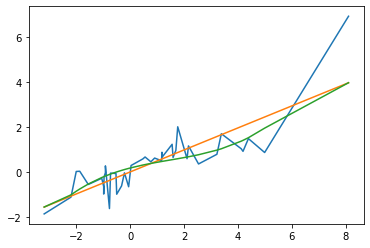

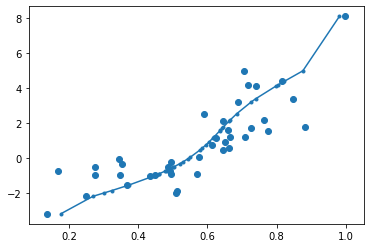

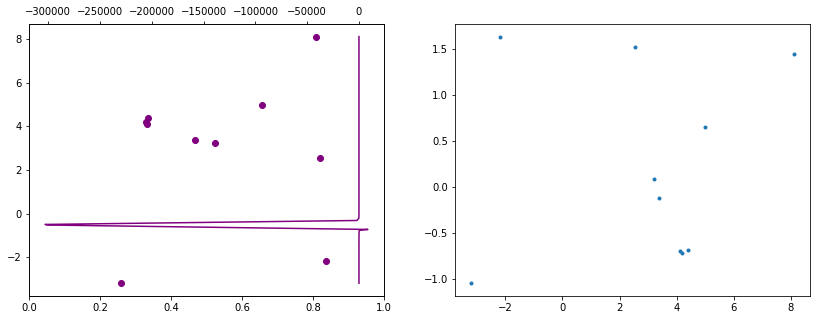

In [166]:
order = np.argsort(neural_expts)
neural_expts_srt = neural_expts[order]
neural_asyms_srt = np.clip(neural_asyms[order], 1e-3, 1-1e-3)

polyfit = np.polynomial.polynomial.Polynomial.fit

plt.plot(neural_expts_srt, sp.logit(neural_asyms_srt))
fit = polyfit(neural_expts_srt, sp.logit(neural_asyms_srt), 1)
plt.plot(neural_expts_srt, fit(neural_expts_srt))

p_ex = np.pad(np.polyfit(neural_expts_srt, sp.logit(neural_asyms_srt), 1), (2, 0))
p_in = np.polyfit(neural_expts_srt, sp.logit(neural_asyms_srt), 3)
p = PiecewisePoly([p_ex, p_in, p_ex], [-3, 8])
plt.plot(neural_expts_srt, p(neural_expts_srt))
plt.show()

plt.scatter(neural_asyms_srt, neural_expts_srt)
plt.plot(sp.expit(p(neural_expts_srt)), neural_expts_srt, marker=".")
plt.show()

test(sp.expit(p(neural_expts_srt)), neural_expts_srt, d=3, mean=0)

In [167]:
# sigh...